## Project: Hybrid Machine Learning Models for CPU Burst Time Prediction

##                COEN 283

## Team: OSSyncro

## Getting Started

This project aims to predict CPU Burst time which is used for CPU scheduling algorithms like Shortest Job First or Shortest Remaining Time First. We proposed several hybrid prediction machine learning models in which combinations of two feature selection techniques, Gradient boosting and Random forest are used. Several machine learning techniques, including Linear Regression, Random Forest Regressor, Support Vector Regressor (SVR), K-Nearest Neighbor (KNN), Decision-Tree (DT), Ridge Regression have been used.

The dataset for this project originates from the http://gwa.ewi.tudelft.nl/datasets/gwa-t-4-auvergrid.


## Exploring the Data


In [42]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import visuals.py module
import visuals as vs
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("CPU Burst Data\cpu_processes_datasets.csv", sep=r'\s*,\s*',
                           header=0, engine='python')


# Success - Display the first record
display(data.head(n=1))
#type(data)// ------------------------

,ï»¿JobID,SubmitTime,WaitTime,RunTime,NProcs,AverageCPUTimeUsed,Used Memory,ReqNProcs,ReqTime:,ReqMemory,...,JobStructureParams,UsedNetwork,UsedLocalDiskSpace,UsedResources,ReqPlatform,ReqNetwork,ReqLocalDiskSpace,ReqResources,VOID,ProjectID
0,1,1136070024,203761,138467,1,138371,98652,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


### Implementation: Data Exploration
An overview of the dataset suggested that there are multiple records that doesn't have labels present. It is necessary to eliminate those records.

In [43]:
#Total number of records
data = data.rename(columns={'ï»¿JobID': 'JobID'})
total_records = data.JobID.count()# -------------------------------------------

# Number of records where cpu burst time is present as record label
label_present = data[data['RunTime'] != -1]['JobID'].count()

# Number of records where cpu burst time is not present
label_absent =  data[data['RunTime'] == -1]['JobID'].count()

# Percentage of individuals whose income is more than $50,000
percent_present = round((label_present/total_records)*100,2)

# Print the results
print("Total number of records: {}".format(total_records))
print("Number of records with labels {}".format(label_present))
print("Number of records without labels {}".format(label_absent))
print("Percentage of records with labels: {}%".format(percent_present))

Total number of records: 404176
Number of records with labels 347611
Number of records without labels 56565
Percentage of records with labels: 86.0%


## Featureset Exploration

*  **JobID**:		counter
*  **SubmitTime**:		in seconds, starting from zero
*  **WaitTime**:		in seconds
*  **RunTime**: 		runtime measured in wallclock seconds
*  **NProcs**:		number of allocated processors
*  **AverageCPUTimeUsed**:	average of CPU time over all allocated processors
*  **Used Memory**:	average per processor in kilobytes
*  **ReqNProcs**:		requested number of processors
* **ReqTime**: 		requested time measured in wallclock seconds
* **ReqMemory**:		requested memory (average per processor)
* **Status**:		job completed = 1, job failed = 0, job cancelled = 5
* **UserID**:		string identifier for user
* **GroupID**:		string identifier for group user belongs to
* **ExecutableID**:	name of executable
* **QueueID**:		string identifier for queue
* **PartitionID**:	string identifier for partition
* **OrigSiteID**:		string identifier for submission site
* **LastRunSiteID**:	string identifier for execution site
* **JobStructure**:	single job = UNITARY, composite job = BoT
* **JobStructureParams**: if JobStructure = BoT, contains batch identifier
* **UsedNetwork**:	used network resources in kilobytes/second
* **UsedLocalDiskSpace**:	in megabytes
* **UsedResources**:	list of comma-separated generic resources (ResourceDescription:Consumption) 
* **memory usage**: in Gb seconds, io data transferred, and io wait time in seconds 
* **ReqPlatform**:	CPUArchitecture,OS,OSVersion
* **ReqNetwork**:		in kilobytes/second
* **ReqLocalDiskSpace**:	in megabytes
* **ReqResources**:	list of comma-separated generic resources (ResourceDescription:Consumption)
* **VOID**:		identifier for Virtual Organization
* **ProjectID**:		identifier for project

**(fields contain -1 if not available)**

----
## Preparing the Data

This data has alot of missing values and must be cleaned, formatted, and restructured. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Cleaning Dataset
Dropping columns having values -1 i.e no information available, hence no useful 

In [44]:
#Deleting all rows having BurstTime == -1 
data = data[data.RunTime != -1]
total_data_count = data.RunTime.count()

#Dropping columns having more than 90% of the missing values (-1)
threshold = 80
colNames = ["ReqMemory","JobStructure","JobStructureParams","UsedNetwork", "UsedLocalDiskSpace","UsedResources","ReqPlatform","ReqNetwork","ReqLocalDiskSpace", "ReqResources","VOID","ProjectID"
]
def removeColumns(colName):
    missingRows = data[data["{}".format(colName)] == -1].JobID.count()
    print("Column {} has {} missing values".format(colName, missingRows))
    if (threshold <= (missingRows/total_data_count)*100):
        data.drop("{}".format(colName), axis = 1, inplace=True)
        print("Dropped {} column".format(colName))
        
for col in colNames:
    removeColumns(col)

Column ReqMemory has 311780 missing values
Dropped ReqMemory column
Column JobStructure has 347611 missing values
Dropped JobStructure column
Column JobStructureParams has 347611 missing values
Dropped JobStructureParams column
Column UsedNetwork has 347611 missing values
Dropped UsedNetwork column
Column UsedLocalDiskSpace has 347611 missing values
Dropped UsedLocalDiskSpace column
Column UsedResources has 347611 missing values
Dropped UsedResources column
Column ReqPlatform has 347611 missing values
Dropped ReqPlatform column
Column ReqNetwork has 347611 missing values
Dropped ReqNetwork column
Column ReqLocalDiskSpace has 347611 missing values
Dropped ReqLocalDiskSpace column
Column ReqResources has 347611 missing values
Dropped ReqResources column
Column VOID has 347611 missing values
Dropped VOID column
Column ProjectID has 347611 missing values
Dropped ProjectID column


In [56]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score


def distribution(feature1, feature2, data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['{}'.format(feature1),'{}'.format(feature2)]):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 10000, 20000, 30000, 50000])
        ax.set_yticklabels([0, 10000, 20000, 30000, ">50000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.savefig('After-Skew.png', dpi=200)
    fig.show()

### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`Wait Time`, `'Average CPU Time Used'`, `'Used Memory'`, `'Req Time'`. 


Number of Rows: 347611
Number of Columns: 17


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


NameError: name 'fig' is not defined

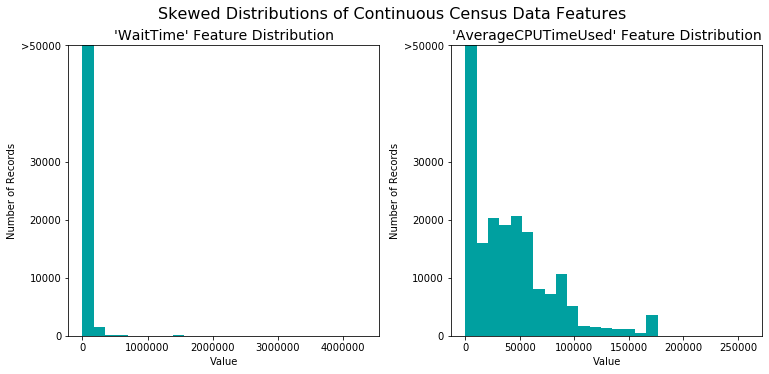

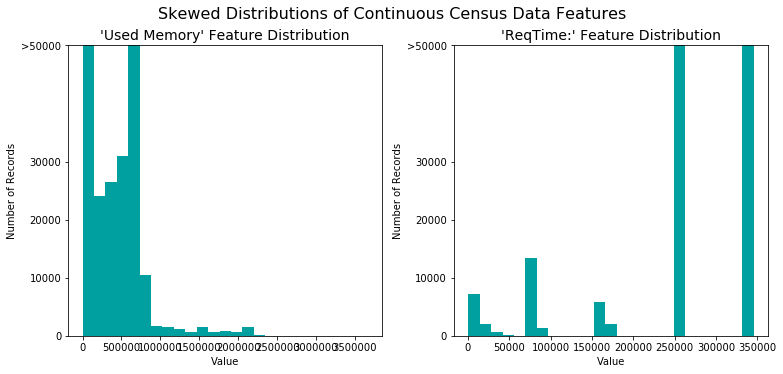

In [54]:
# Latest Shape of Dataset after removing missing values from rows and columns
print("Number of Rows:", data.shape[0])
print("Number of Columns:", data.shape[1])

# Split the data into features and target label
actual_burstTime = data['RunTime']
features_Set = data.drop('RunTime', axis = 1)

#vs.distribution(income_raw)

# Visualize skewed continuous features of original data
distribution('WaitTime','AverageCPUTimeUsed',data)
distribution('Used Memory','ReqTime:',data)
fig.savefig('Before-Skew.png', dpi=200)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


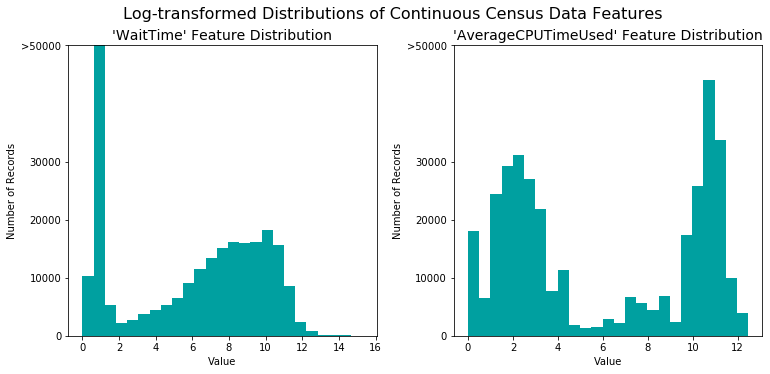

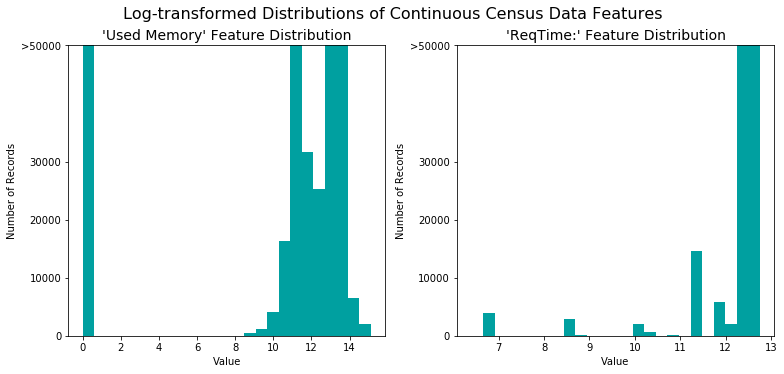

In [53]:
# Log-transform the skewed features
#print(features_raw[skewed])

skewed = ['WaitTime', 'AverageCPUTimeUsed','Used Memory','ReqTime:']
features_log_transformed = pd.DataFrame(data = features_Set)
features_log_transformed[skewed] = features_Set[skewed].apply(lambda x: np.log(x + 1))
#print(features_log_transformed[skewed])

# Visualize the new log distributions
distribution('WaitTime','AverageCPUTimeUsed',features_log_transformed, transformed = True)
distribution('Used Memory','ReqTime:',features_log_transformed, transformed = True)
fig.savefig('After-Skew.png', dpi=200)

### Normalizing Numerical Features


In [8]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['WaitTime', 'NProcs', 'AverageCPUTimeUsed', 'Used Memory', 'ReqNProcs','ReqTime:','SubmitTime']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
#print(features_log_minmax_transform)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))


,JobID,SubmitTime,WaitTime,NProcs,AverageCPUTimeUsed,Used Memory,ReqNProcs,ReqTime:,Status,UserID,GroupID,ExecutableID,QueueID,PartitionID,OrigSiteID,LastRunSiteID
0,1,0.000000,0.799804,0.0,0.949614,0.760788,0.0,0.954728,1,U2004S1,G3,X1,Q5,1,clrlcgce02,clrlcgce02
1,2,0.000021,0.000000,0.0,0.129108,0.693816,0.0,0.954728,1,U1023S0,G1,X1,Q1,1,clrlcgce01,clrlcgce01
2,3,0.000038,0.312123,0.0,0.000000,0.000000,0.0,0.954728,1,U2035S1,G6,X1,Q2,1,clrlcgce02,clrlcgce02
3,4,0.000039,0.548980,0.0,0.000000,0.000000,0.0,0.954728,1,U2035S1,G6,X1,Q2,1,clrlcgce02,clrlcgce02
4,5,0.000039,0.799403,0.0,0.789198,0.871048,0.0,0.954728,1,U2035S1,G6,X1,Q2,1,clrlcgce02,clrlcgce02


### Implementation: Data Preprocessing

There are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |


In [10]:
features_final = pd.get_dummies(features_log_minmax_transform)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print(" {} total features after one-hot encoding.".format(len(encoded)))



 460 total features after one-hot encoding.


In [37]:
#Labels

print(actual_burstTime)

0         138467
1             11
2         201203
3         196985
4          19520
           ...  
404170        41
404171        56
404172        57
404173        45
404174        43
Name: RunTime, Length: 347611, dtype: int64


### Shuffle and Split Data
Till now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. 
We will now split the data into training and test sets. 80% of the data will be used for training and 20% for testing.


In [11]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    actual_burstTime, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0])) #shape[0] it checks no of rows
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 278088 samples.
Testing set has 69523 samples.


## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

###  Supervised Learning Models

- LinearRegression
- Decision Trees
- Ensemble Methods (Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Support Vector Regressor (SVM)
- Ridge Regression

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, predictions):
    error = 0
    y_true, predictions = np.array(y_true), np.array(predictions)
    for i in range(len(predictions)):
        error += abs(y_true[i] - predictions[i])/y_true[i]
    return error/len(y_true)

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    print("learner", learner)
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    results['MAE_train'] = mean_absolute_error(y_train[:300], predictions_train)
            
    #Compute MAE_Test on test set using accuracy_score()
    results['MAE_test'] = mean_absolute_error(y_test,predictions_test)
    
    # Compute R2-Score on the the first 300 training samples using fbeta_score()
    results['R2_train'] = r2_score(y_train[:300],predictions_train)
        
    # Compute R2-Score on the test set which is y_test
    results['R2_test'] = r2_score(y_test,predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

- Import the three supervised learning models from the previous section.
- Initializing the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.



In [38]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score, accuracy_score


def distribution(data, transformed = False):
    """
    Visualization code for displaying skewed distributions of features
    """
    
    # Create figure
    fig = pl.figure(figsize = (11,5));

    # Skewed feature plotting
    for i, feature in enumerate(['WaitTime','AverageCPUTimeUsed']):
        ax = fig.add_subplot(1, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 2000))
        ax.set_yticks([0, 500, 1000, 1500, 2000])
        ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()


def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = pl.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'MAE_train', 'R2_train', 'pred_time', 'MAE_test', 'R2_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Mean Abs Error Score")
    ax[0, 2].set_ylabel("R2 score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Mean Abs Error Score")
    ax[1, 2].set_ylabel("R2 score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("MAE Score on Training Subset")
    ax[0, 2].set_title("R2 on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("MAE Score Test Set")
    ax[1, 2].set_title("R2 on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 10000))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 10000))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    pl.tight_layout()
    pl.savefig('Performance.png', dpi=200)
    pl.show()
    

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()  


learner LinearRegression()
LinearRegression trained on 2780 samples.
learner LinearRegression()
LinearRegression trained on 27808 samples.
learner LinearRegression()
LinearRegression trained on 278088 samples.
learner RandomForestRegressor(max_depth=2, random_state=0)
RandomForestRegressor trained on 2780 samples.
learner RandomForestRegressor(max_depth=2, random_state=0)
RandomForestRegressor trained on 27808 samples.
learner RandomForestRegressor(max_depth=2, random_state=0)
RandomForestRegressor trained on 278088 samples.
learner Ridge(alpha=0.5)
Ridge trained on 2780 samples.
learner Ridge(alpha=0.5)
Ridge trained on 27808 samples.
learner Ridge(alpha=0.5)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.25792e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge trained on 278088 samples.


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


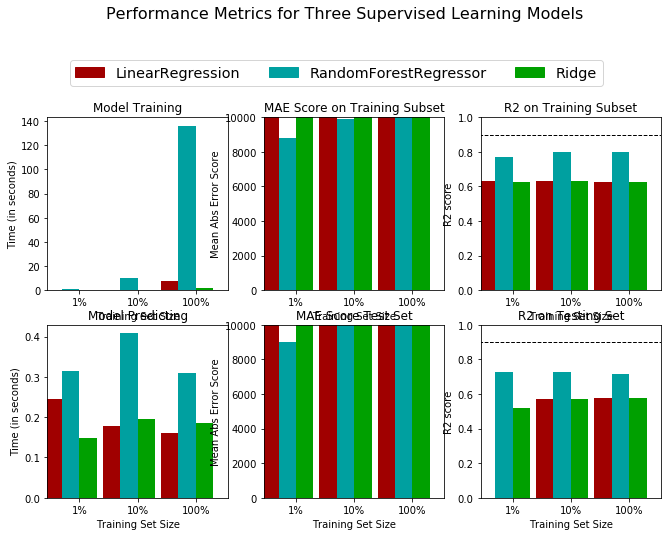

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

clf_A = LinearRegression()
clf_B = RandomForestRegressor(max_depth=2, random_state=0)
clf_C = Ridge(alpha = 0.5)

# Calculate the number of samples for 1%, 10%, and 100% of the training data

def get_sample_size(percentage):
    return int((float(percentage)/100)*X_train.shape[0])

samples_1 = get_sample_size(1.0)
samples_10 = get_sample_size(10.0)
samples_100 = get_sample_size(100.0)
# Collect results on the learners
results = {}
for clf in [clf_A,clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, 0.8, 0.9)

learner KNeighborsRegressor(n_neighbors=2)
KNeighborsRegressor trained on 2780 samples.
learner KNeighborsRegressor(n_neighbors=2)
KNeighborsRegressor trained on 27808 samples.
learner KNeighborsRegressor(n_neighbors=2)
KNeighborsRegressor trained on 278088 samples.
learner Lasso(alpha=0.1)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+12, tolerance: 6.353e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso trained on 2780 samples.
learner Lasso(alpha=0.1)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+13, tolerance: 4.723e+09
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso trained on 27808 samples.
learner Lasso(alpha=0.1)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.852e+13, tolerance: 4.637e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso trained on 278088 samples.
learner DecisionTreeRegressor()
DecisionTreeRegressor trained on 2780 samples.
learner DecisionTreeRegressor()
DecisionTreeRegressor trained on 27808 samples.
learner DecisionTreeRegressor()
DecisionTreeRegressor trained on 278088 samples.


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


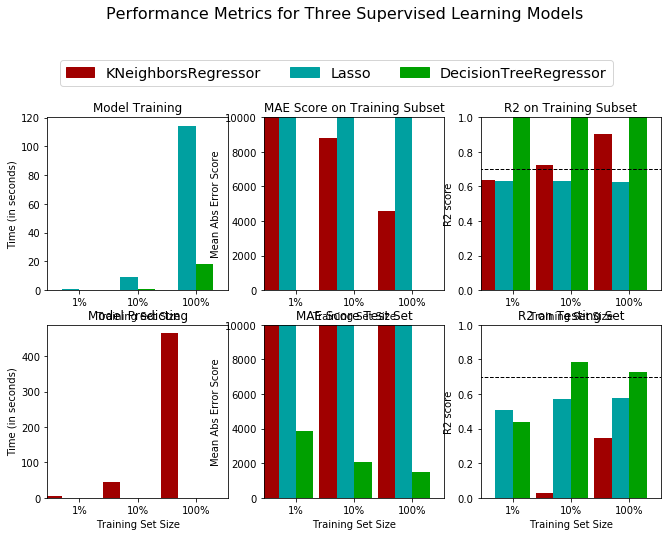

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import tree

results = {}
clf_A = KNeighborsRegressor(n_neighbors=2)
clf_B = linear_model.Lasso(alpha=0.1)
clf_C = tree.DecisionTreeRegressor()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
def get_sample_size(percentage):
    return int((float(percentage)/100)*X_train.shape[0])

samples_1 = get_sample_size(1.0)
samples_10 = get_sample_size(10.0)
samples_100 = get_sample_size(100.0)
# Collect results on the learners
results = {}
for clf in [clf_A,clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# metrics visualization for the three supervised learning models chosen
evaluate(results, 0.7, 0.7)

----
## Improving Results

We will perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning several parameter to improve upon the untuned model's R2-score. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values.


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()

# Create the parameters list you wish to tune, using a dictionary if needed.
#parameters = {'solver':['newton-cg','lbfgs'], 'max_iter':[10,100,200,300]}
parameters_={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9],
           "min_samples_leaf":[1,2,3,4,5,6,7,8],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70]}

parameters={"splitter":["best"],
            "max_depth" : [9],
           "min_samples_leaf":[5],
           "max_features":["auto"],
           "max_leaf_nodes":[None]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(r2_score, beta=0.5)
# Prform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,param_grid=parameters,scoring='r2',cv=3,verbose=3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, splitter=best;, score=0.845 total time=   4.4s
[CV 2/3] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, splitter=best;, score=0.849 total time=   4.3s
[CV 3/3] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=5, splitter=best;, score=0.897 total time=   4.4s


In [42]:
# Report: before-and-afterscores
print("Unoptimized model\n------")
print("R2-Score on testing data: {:.4f}".format(r2_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final R2 Score on the testing data: {:.4f}".format(r2_score(y_test, best_predictions)))

#saving trained model as Pickel file
from joblib import Parallel, delayed
import joblib
  
#Save the model as a pickle in a file
joblib.dump(best_clf, 'TrainedDecisionTree.pkl')
  
# Use the loaded model to make predictions
#knn_from_joblib.predict(X_test)

Unoptimized model
------
R2-Score on testing data: 0.7816

Optimized Model
------
Final R2 Score on the testing data: 0.8894


['TrainedDecisionTree.pkl']

### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| R2-Score       |      0.7816       |     0.8894      |



----
## Feature Importance

### Implementation - Extracting Feature Importance
We have used GradientBoosterClassifier and RandomForest for feature selection and setting it's importance. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

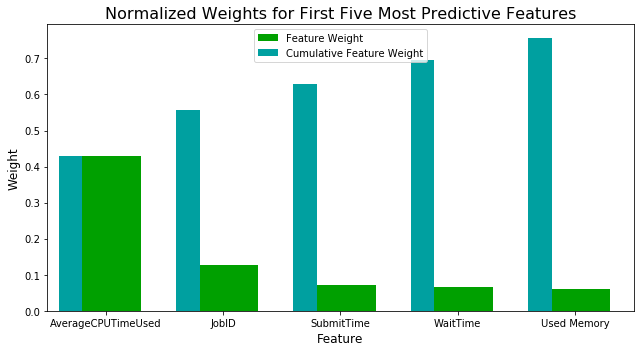

In [16]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier

X_train_new = features_final.head(100)
y_train_new = actual_burstTime.head(100)
# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(n_estimators=20, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_new, y_train_new)
model.fit(X_train_new,y_train_new)

# TODO: Extract the feature importances using .feature_importances_ b
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train_new, y_train_new)

In [17]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 

before_encoding = features_log_minmax_transform

label_encoder = preprocessing.LabelEncoder() 
before_encoding['UserID'] = label_encoder.fit_transform(before_encoding['UserID']) 
before_encoding['GroupID'] = label_encoder.fit_transform(before_encoding['GroupID']) 
before_encoding['ExecutableID'] = label_encoder.fit_transform(before_encoding['ExecutableID']) 
before_encoding['QueueID'] = label_encoder.fit_transform(before_encoding['QueueID']) 
before_encoding['OrigSiteID'] = label_encoder.fit_transform(before_encoding['OrigSiteID']) 
before_encoding['LastRunSiteID'] = label_encoder.fit_transform(before_encoding['LastRunSiteID']) 
print(before_encoding.head())
X_train_new = before_encoding.head(100)

   JobID  SubmitTime  WaitTime  NProcs  AverageCPUTimeUsed  Used Memory  \
0      1    0.000000  0.799804     0.0            0.949614     0.760788   
1      2    0.000021  0.000000     0.0            0.129108     0.693816   
2      3    0.000038  0.312123     0.0            0.000000     0.000000   
3      4    0.000039  0.548980     0.0            0.000000     0.000000   
4      5    0.000039  0.799403     0.0            0.789198     0.871048   

   ReqNProcs  ReqTime:  Status  UserID  GroupID  ExecutableID  QueueID  \
0        0.0  0.954728       1     132        2             0        8   
1        0.0  0.954728       1      26        0             0        0   
2        0.0  0.954728       1     166        5             0        5   
3        0.0  0.954728       1     166        5             0        5   
4        0.0  0.954728       1     166        5             0        5   

   PartitionID  OrigSiteID  LastRunSiteID  
0            1           1              1  
1            1  

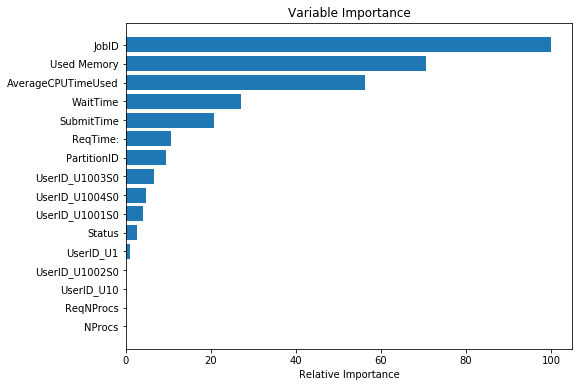

In [34]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=0)
clf.fit(X_train_new, y_train_new)
%matplotlib inline

# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('Gradient_Feature.png', dpi=200)
plt.show()


### Feature Selection


In [35]:
# Split the 'features' and 'income' data into training and testing sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(before_encoding, 
                                                    actual_burstTime, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train_new.shape[0])) #shape[0] it checks no of rows
print("Testing set has {} samples.".format(X_test_new.shape[0]))


Training set has 278088 samples.
Testing set has 69523 samples.


In [36]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space

X_train_reduced = X_train_new[X_train_new.columns.values[(np.argsort(feature_importance)[::-1])[:10]]]
X_test_reduced = X_test_new[X_test_new.columns.values[(np.argsort(feature_importance)[::-1])[:10]]]

# Train on the "best" model found from grid search earlier
# Load the model from the file
clf = (clone(best_clf)).fit(X_train_reduced, y_train_new)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(r2_score(y_test_new, best_predictions)))
print("F-score on testing data: {:.4f}".format(mean_absolute_error(y_test_new, best_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(r2_score(y_test_new, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(mean_absolute_error(y_test_new, reduced_predictions)))

NameError: name 'best_clf' is not defined

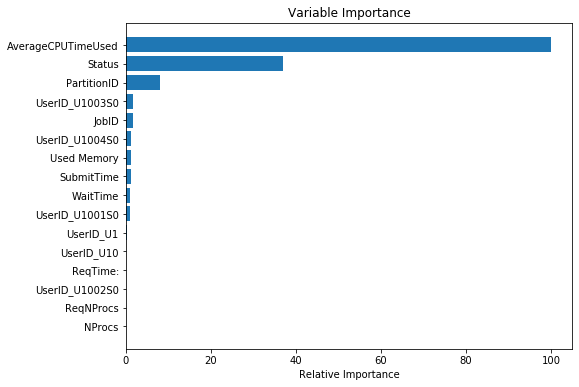

In [37]:
## Feature Selection using Random Forest
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train_new.head(200), y_train_new.head(200))

# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('RF_Feature.png', dpi=200)
plt.show()

In [56]:
X_train_reduced = X_train_new[X_train_new.columns.values[(np.argsort(feature_importance)[::-1])[:10]]]
X_test_reduced = X_test_new[X_test_new.columns.values[(np.argsort(feature_importance)[::-1])[:10]]]

# Train on the "best" model found from grid search earlier
# Load the model from the file
clf = (clone(best_clf)).fit(X_train_reduced, y_train_new)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(r2_score(y_test_new, best_predictions)))
print("F-score on testing data: {:.4f}".format(mean_absolute_error(y_test_new, best_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(r2_score(y_test_new, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(mean_absolute_error(y_test_new, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.8894
F-score on testing data: 2973.4186

Final Model trained on reduced data
------
Accuracy on testing data: 0.8772
F-score on testing data: 2965.2617


### Effects of Feature Selection







|     Metric     |   Benchmark model | Unoptimized Model | Optimized Model    | Reduced features Model | 
| :------------: | :---------------: | :-------------:   | :------------:     | :--------------------: |
| R2 Score       |    0.70           |    0.7816         |   0.90             |      0.8284            |


- As expected, reducing the number of features has a negative impact upon our model. The optimized model has performed significantly well - increased the R2 Score from 0.7816 to 0.889 (~0.90).

- Moreover, Selecting important features havn't contributed much in this case as reducing features from 16 to 10 has decreased the R2 score to 0.8284 